# Generating realistic synthetic data sets.

In this notebook, we give a step-by-step explanation on to generate synthetic realistic data and labels for the experiments of the paper.

- **Data:** The data points $x^{\mu}\in\mathbb{R}^{D}$ are grayscale CIFAR10-like images sampled from a trained dcGAN that maps i.i.d. Gaussian noise to realistic looking images $\mathcal{G}:z \sim \mathcal{N}(0,\rm{I}_{100}) \to x \in \mathbb{R}^{D}$. 

- **Labels:** The labels $y^{\mu}\in\{-1, +1\}$ are assigned to the dcGAN generated images using teacher features $\varphi_{t}:\mathbb{R}^{D}\to\mathbb{R}^{p}$ and teacher weights $\theta_{0}\in\mathbb{R}^{p}$ trained on real grayscale CIFAR10 images. In this example, the teacher is a fully-connected neural network trained of a odd (+1) vs even (-1) classification task on real grayscale CIFAR10 images. The first layers of the teacher define the feature map and the last layer the teacher weights.

In [114]:
odd = ('car', 'cat', 'dog', 'horse', 'truck')
even = ('plane', 'bird', 'deer', 'frog', 'ship')

## Loading the generator (dcGAN)

We start by loading our generator defining the map $z\sim\mathcal{N}(0,\rm{I}_{d}) \mapsto x\in\mathbb{R}^{D}$. In all experiments in the manuscript, we used a trained dcGAN from [Radford et al.](https://arxiv.org/abs/1511.06434).

In [42]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from dcgan import Generator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# Load the generator
generator = Generator(ngpu=1)
generator.load_state_dict(torch.load("./data/weights/dcgan_cifar10_weights.pth", map_location=device))

print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): Tanh()
  )
)


Now let's generate a couple of images to see how they look like.

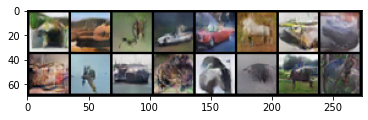

In [78]:
latent_dim = 100
samples = 16

Z = torch.randn(samples, latent_dim, 1, 1).to(device)
imgs = generator(Z).detach()

_, c, dx, dy = imgs.shape

ims = torchvision.utils.make_grid(imgs, normalize=True)
plt.imshow(ims.numpy().transpose((1,2,0)))
plt.show()

In [75]:
imgs.shape

torch.Size([16, 3, 32, 32])

To reduce dimensionality and speed up the experiment, we prefer to work with grayscale images.

In [76]:
def to_grayscale(xs):
    """
    Converts a tensor containing RGB images, where x.shape is (batch_size, 3, height, width), 
    to a tensor with grayscale images.
    
    This is a batch-version of the functional form of the pyTorch transform.
    """
    # values taken from pyTorch implementation:
    # https://github.com/pytorch/vision/blob/master/torchvision/transforms/functional_tensor.py
    code = torch.tensor([0.2989, 0.587, 0.114])
    xs = torch.einsum("...jkl,j", xs, code)
    return xs

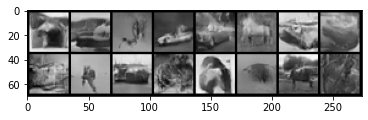

In [79]:
imgs_gray = to_grayscale(imgs).reshape(samples, 1, dx, dy)

ims_gray = torchvision.utils.make_grid(imgs_gray, normalize=True)
plt.imshow(ims_gray.numpy().transpose((1,2,0)))
plt.show()

## Loading the teacher

We now load our pre-trained teacher that will assign the labels to the grayscale CIFAR10-like images. This teacher has been trained on real grayscale CIFAR10 images on a odd (+1) vs even (-1) classification task.

In [87]:
import teachers
import teacherutils

In [96]:
D = dx * dy

# Load teacher vector
kwargs = {"input_dim": [1, dx, dy]}
teacher_mlp = teacherutils.get_model("mlp", "erf", D, 1, **kwargs)
teacher_mlp.load_state_dict(torch.load("./data/weights/mlp_erf_cifar10_gray.pt", 
                                       map_location=device))

print(teacher_mlp)

MLP(
  (preprocess1): Linear(in_features=1024, out_features=1024, bias=False)
  (preprocess2): Linear(in_features=1024, out_features=1024, bias=False)
  (preprocess3): Linear(in_features=1024, out_features=1024, bias=False)
  (bnz): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (fc): Linear(in_features=1024, out_features=1, bias=False)
  (v): Linear(in_features=1, out_features=1, bias=False)
)


The teacher weights and feature map can be easily extracted as:

In [107]:
# Teacher weights
p = D # teacher network map 1024 to 1024.
teacher_weights = teacher_mlp.fc.weight.data.numpy()
teacher_weights = teacher_weights.reshape(p,)

# Teacher features (note input should be flattened)
teacher_map = lambda x: teacher_mlp.preprocess(x)

Now let's generate labels for the fake images above.

In [113]:
flat_imgs = imgs_gray.reshape(samples, -1) # flatten images
U = teacher_map(flat_imgs).detach().numpy() # Teacher features
y = np.sign(U @ teacher_weights / np.sqrt(p))